# Implementation LSTM model for Forecasting
### 'My Stock Forecast App' 

In [38]:
import yfinance as yf
from datetime import date
import pandas as pd
import numpy as np
from sklearn import metrics
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## DATA INGESTION

In [40]:
# Input dari pengguna untuk simbol saham
symbol = input("Input simbol saham (e.g 'BBRI.JK'): ")
start_date = date(2019, 1, 1)
end_date = date(2024, 2, 1)

# Mengunduh data saham dari Yahoo Finance # Menambahkan kolom tanggal sebagai indeks
data = yf.download(symbol, start=start_date, end=end_date)

c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [41]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,3327.215332,3327.215332,3327.215332,3327.215332,2594.003906,0
2019-01-02,3281.761475,3309.033691,3263.580078,3281.761475,2558.566895,82441033
2019-01-03,3254.489258,3309.033691,3254.489258,3290.852295,2565.654297,102805905
2019-01-04,3290.852295,3327.215332,3281.761475,3327.215332,2594.003906,125907734
2019-01-07,3363.578369,3372.668945,3327.215332,3327.215332,2594.003906,82106628


In [42]:
data.reset_index(inplace=True)

# Input dari pengguna untuk fitur yang akan digunakan
input_feat = input("Masukkan fitur yang akan digunakan ('Adj Close','Close'): ")


data = data[["Date", input_feat]]# Memilih kolom tanggal dan fitur yang akan digunakan
data

,Date,Close
0,2019-01-01,3327.215332
1,2019-01-02,3281.761475
2,2019-01-03,3290.852295
3,2019-01-04,3327.215332
4,2019-01-07,3327.215332
...,...,...
1249,2024-01-25,5525.000000
1250,2024-01-26,5425.000000
1251,2024-01-29,5575.000000
1252,2024-01-30,5625.000000


## DATA PROCESSING

In [43]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[input_feat].values.reshape(-1, 1))

In [44]:
# Pembagian data menjadi data training dan data testing
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size, :], scaled_data[train_size:, :]

In [45]:
# Persiapan Create Sequences LSTM
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        target.append(data[i+sequence_length])
    return np.array(sequences), np.array(target)

In [46]:
tf.random.set_seed(7)

In [47]:
sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Modelling

In [48]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 50)            10400     
                                                                 
 dropout_6 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

# Training


In [49]:
cp3 = ModelCheckpoint('../model/model1/', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_final = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, callbacks=[cp3, early_stopping], validation_data=(X_test, y_test))

Epoch 1/100


INFO:tensorflow:Assets written to: ../model/model1\assets


INFO:tensorflow:Assets written to: ../model/model1\assets


32/32 - 18s - loss: 0.0546 - accuracy: 0.0010 - val_loss: 0.0082 - val_accuracy: 0.0041 - 18s/epoch - 557ms/step
Epoch 2/100
32/32 - 1s - loss: 0.0078 - accuracy: 0.0010 - val_loss: 0.0237 - val_accuracy: 0.0041 - 637ms/epoch - 20ms/step
Epoch 3/100


INFO:tensorflow:Assets written to: ../model/model1\assets


INFO:tensorflow:Assets written to: ../model/model1\assets


32/32 - 11s - loss: 0.0052 - accuracy: 0.0010 - val_loss: 0.0012 - val_accuracy: 0.0041 - 11s/epoch - 346ms/step
Epoch 4/100
32/32 - 1s - loss: 0.0049 - accuracy: 0.0010 - val_loss: 0.0133 - val_accuracy: 0.0041 - 631ms/epoch - 20ms/step
Epoch 5/100
32/32 - 0s - loss: 0.0063 - accuracy: 0.0010 - val_loss: 0.0060 - val_accuracy: 0.0041 - 461ms/epoch - 14ms/step
Epoch 6/100
Restoring model weights from the end of the best epoch: 3.
32/32 - 0s - loss: 0.0042 - accuracy: 0.0010 - val_loss: 0.0015 - val_accuracy: 0.0041 - 498ms/epoch - 16ms/step
Epoch 6: early stopping


# Evaluation

In [50]:
# Evaluasi model pada data uji
loss = model.evaluate(X_test, y_test)
print("Loss di data uji:", loss)

predict = model.predict(X_test)
# print(predict)

8/8 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 0.0041    
Loss di data uji: [0.0012067165225744247, 0.004149377811700106]
8/8 [==============================] - 1s 8ms/step


In [51]:
print("-"*15, " Metric ","-"*15)
print('RMSE : ', round(sqrt(metrics.mean_squared_error(y_test, predict)), 5))
print('MSE  : ', round(abs(metrics.mean_squared_error(y_test, predict)), 5))
print('MAE  : ', round(metrics.mean_absolute_error(y_test, predict), 5))

---------------  Metric  ---------------
RMSE :  0.03474
MSE  :  0.00121
MAE  :  0.02789


# Visualization

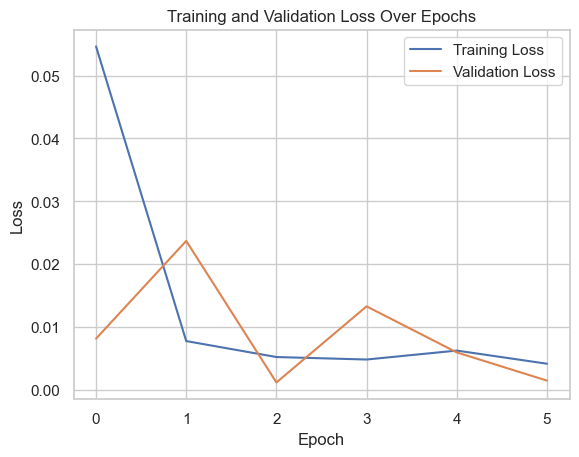

In [52]:
# Plot loss
sns.set(style="whitegrid")

sns.lineplot(x=range(len(model_final.history['loss'])), y=model_final.history['loss'], label='Training Loss')
sns.lineplot(x=range(len(model_final.history['val_loss'])), y=model_final.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Saving Model

In [53]:
# Simpan model
# model.save("../home-page-stock-prediction/lstm_model2.keras")
model.save("lstm_model1.keras")
print("Successfully save model")

Successfully save model
